# Opcode usage - exploratory analysis

#### Maria Silva, April 2025

## 1. Imports and settings

Let's start by importing the necessary libraries and setting up some directories and files.


In [1]:
import os
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Main directories and files
current_path = os.getcwd()
repo_dir = os.path.abspath(os.path.join(current_path, ".."))
data_dir = os.path.join(repo_dir, "data")
op_files_dir = os.path.join(data_dir, "aggregated_opcodes_v2", "*", "file.parquet")

## 2. Load data

Now, let's load the data. We will start by loading the opcodes used for blocks 22000000 to 22001999.

In [3]:
# Load parquet files with duckdb
query = f"""
SELECT block_height, tx_hash, op, op_gas_cost, op_gas_pair_count
FROM read_parquet(
    '{op_files_dir}', 
    hive_partitioning=True, 
    filename=True,
    file_row_number=True,
    union_by_name=True
    )
WHERE block_height BETWEEN 22000000 AND 22001999;
"""
raw_usage_df = duckdb.connect().execute(query).fetchdf()
# Print info
raw_usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13518730 entries, 0 to 13518729
Data columns (total 5 columns):
 #   Column             Dtype  
---  ------             -----  
 0   block_height       int64  
 1   tx_hash            object 
 2   op                 object 
 3   op_gas_cost        float64
 4   op_gas_pair_count  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 515.7+ MB


In [4]:
raw_usage_df["block_height"].agg(["min", "max"])

min    22000020
max    22001999
Name: block_height, dtype: int64

Note that we only have data starting at 22000020. Now, we can load the gas used per transaction.

In [26]:
# Load parquet file
tx_gas_usage_df = pd.read_parquet(
    os.path.join(data_dir, "tx_gas_usage_22000000_22006000.parquet")
)
# Clean up columns
tx_gas_usage_df = tx_gas_usage_df.drop(columns=["block_height"])
tx_gas_usage_df.columns = [
    "tx_hash",
    "tx_gas_cost",
    "tx_gas_limit",
    "tx_input_data_gas_cost",
    "is_contract_creation",
    "is_success"
]
# Print info
tx_gas_usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937679 entries, 0 to 937678
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   tx_hash                 937679 non-null  object
 1   tx_gas_cost             937679 non-null  int64 
 2   tx_gas_limit            937679 non-null  int64 
 3   tx_input_data_gas_cost  937679 non-null  int64 
 4   is_contract_creation    937679 non-null  int64 
 5   is_success              937679 non-null  object
dtypes: int64(4), object(2)
memory usage: 42.9+ MB


## 3. Process data

In [27]:
# Add total transaction gas
usage_df = raw_usage_df.merge(tx_gas_usage_df, on="tx_hash", how="left")
# Fix op_gas_cost for transactions with no opcodes
usage_df["op_gas_cost"] = np.where(
    (usage_df["op"].isin(["NO_TRACE", "RESPONSE_TOO_LARGE"])) & (usage_df["is_contract_creation"]==0),
    usage_df["tx_gas_cost"] - usage_df["tx_input_data_gas_cost"] - 21000.0,
    usage_df["op_gas_cost"],
)
usage_df["op_gas_cost"] = np.where(
    (usage_df["op"].isin(["NO_TRACE", "RESPONSE_TOO_LARGE"])) & (usage_df["is_contract_creation"]==1),
    usage_df["tx_gas_cost"] - usage_df["tx_input_data_gas_cost"] - 53000.0,
    usage_df["op_gas_cost"],
)
# Clean up repeated opcodes
usage_df["op"] = np.where(usage_df["op"].str.startswith("DUP"), "DUP", usage_df["op"])
usage_df["op"] = np.where(usage_df["op"].str.startswith("SWAP"), "SWAP", usage_df["op"])
usage_df["op"] = np.where(
    (usage_df["op"].str.startswith("PUSH")) & (usage_df["op"] != "PUSH0"),
    "PUSH",
    usage_df["op"],
)
# Compute total gas cost for opcode
usage_df["op_total_gas_cost"] = usage_df["op_gas_cost"] * usage_df["op_gas_pair_count"]
# Print info
usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13518730 entries, 0 to 13518729
Data columns (total 11 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   block_height            int64  
 1   tx_hash                 object 
 2   op                      object 
 3   op_gas_cost             float64
 4   op_gas_pair_count       int64  
 5   tx_gas_cost             int64  
 6   tx_gas_limit            int64  
 7   tx_input_data_gas_cost  int64  
 8   is_contract_creation    int64  
 9   is_success              object 
 10  op_total_gas_cost       float64
dtypes: float64(2), int64(6), object(3)
memory usage: 1.1+ GB


## 4. Opcode usage overview

### Opcode usage counts

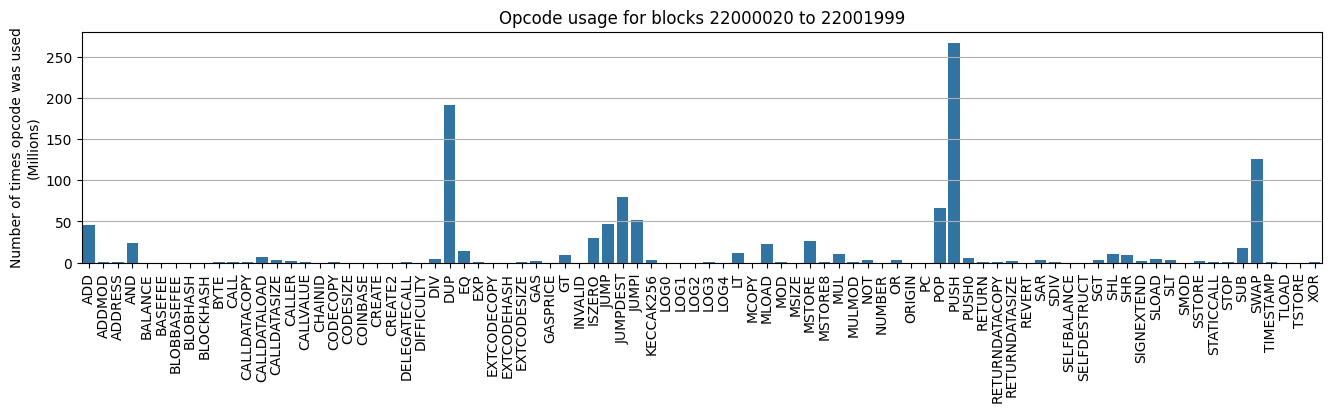

In [7]:
temp_df = (
    usage_df[~usage_df["op"].isin(["NO_TRACE", "RESPONSE_TOO_LARGE"])]
    .groupby("op")["op_gas_pair_count"]
    .sum()
    .reset_index()
)
temp_df["op_gas_pair_count"] = temp_df["op_gas_pair_count"] / 1_000_000
plt.figure(figsize=(16, 3))
plt.grid()
sns.barplot(x="op", y="op_gas_pair_count", data=temp_df)
plt.xticks(rotation=90)
plt.title("Opcode usage for blocks 22000020 to 22001999")
plt.ylabel("Number of times opcode was used\n(Millions)")
plt.xlabel("")
plt.show()

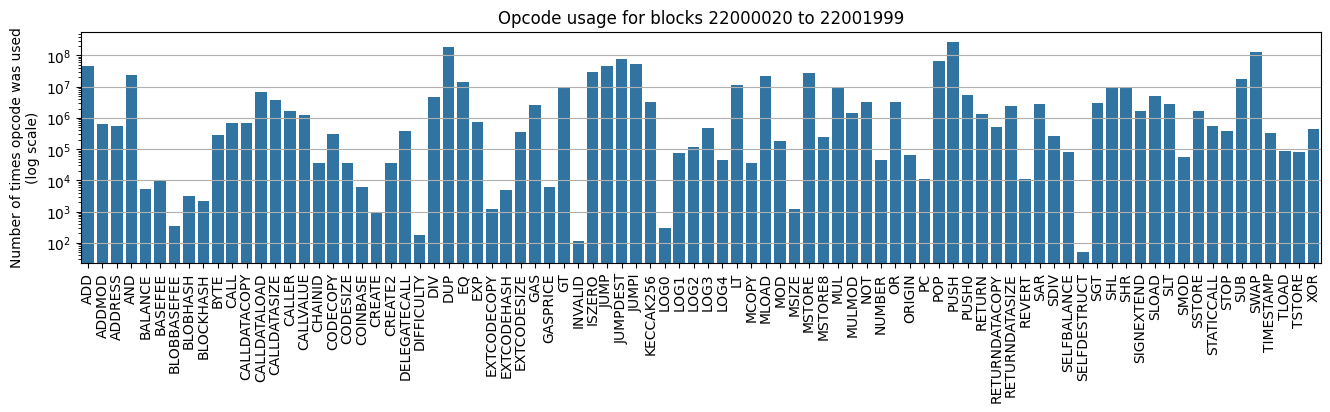

In [8]:
temp_df = (
    usage_df[~usage_df["op"].isin(["NO_TRACE", "RESPONSE_TOO_LARGE"])]
    .groupby("op")["op_gas_pair_count"]
    .sum()
    .reset_index()
)
temp_df["op_gas_pair_count"] = temp_df["op_gas_pair_count"]
plt.figure(figsize=(16, 3))
plt.grid()
sns.barplot(x="op", y="op_gas_pair_count", data=temp_df)
plt.xticks(rotation=90)
plt.yscale("log")
plt.title("Opcode usage for blocks 22000020 to 22001999")
plt.ylabel("Number of times opcode was used\n(log scale)")
plt.xlabel("")
plt.show()

### Opcode gas usage

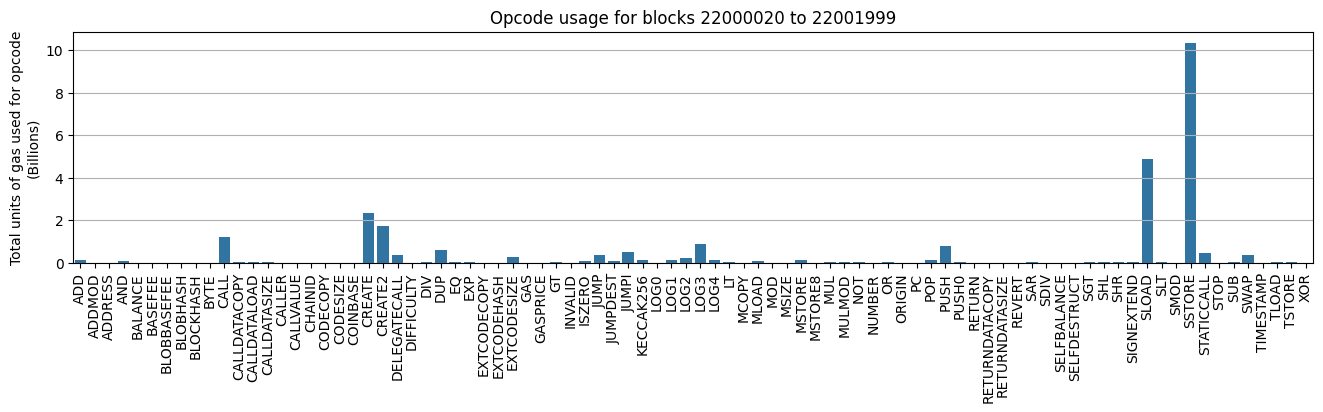

In [9]:
temp_df = (
    usage_df[~usage_df["op"].isin(["NO_TRACE", "RESPONSE_TOO_LARGE"])]
    .groupby("op")["op_total_gas_cost"]
    .sum()
    .reset_index()
)
temp_df["op_total_gas_cost"] = temp_df["op_total_gas_cost"] / 1_000_000_000
plt.figure(figsize=(16, 3))
plt.grid()
sns.barplot(x="op", y="op_total_gas_cost", data=temp_df)
plt.xticks(rotation=90)
plt.title("Opcode usage for blocks 22000020 to 22001999")
plt.ylabel("Total units of gas used for opcode\n(Billions)")
plt.xlabel("")
plt.show()

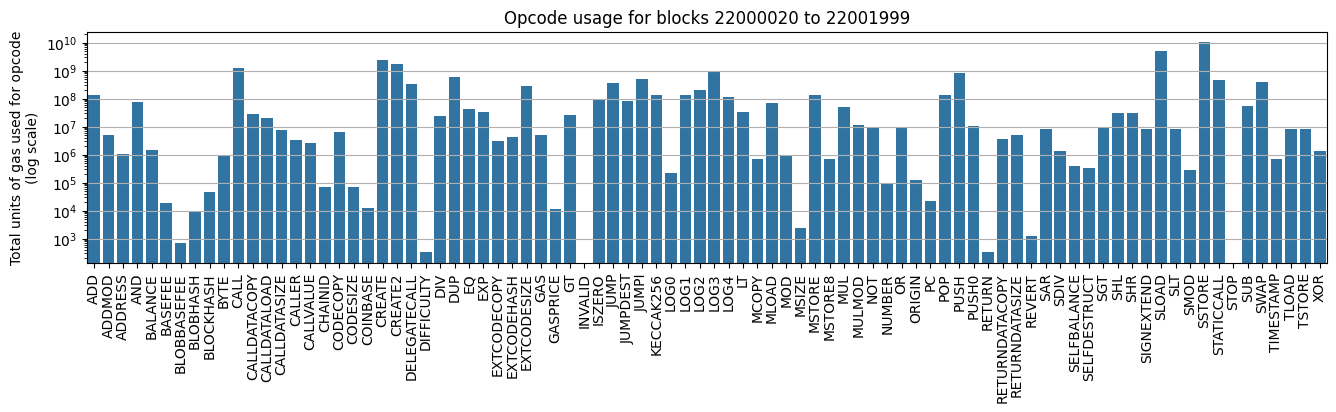

In [10]:
temp_df = (
    usage_df[~usage_df["op"].isin(["NO_TRACE", "RESPONSE_TOO_LARGE"])]
    .groupby("op")["op_total_gas_cost"]
    .sum()
    .reset_index()
)
temp_df["op_total_gas_cost"] = temp_df["op_total_gas_cost"]
plt.figure(figsize=(16, 3))
plt.grid()
sns.barplot(x="op", y="op_total_gas_cost", data=temp_df)
plt.xticks(rotation=90)
plt.yscale("log")
plt.title("Opcode usage for blocks 22000020 to 22001999")
plt.ylabel("Total units of gas used for opcode\n(log scale)")
plt.xlabel("")
plt.show()

### Opcode usage correlation

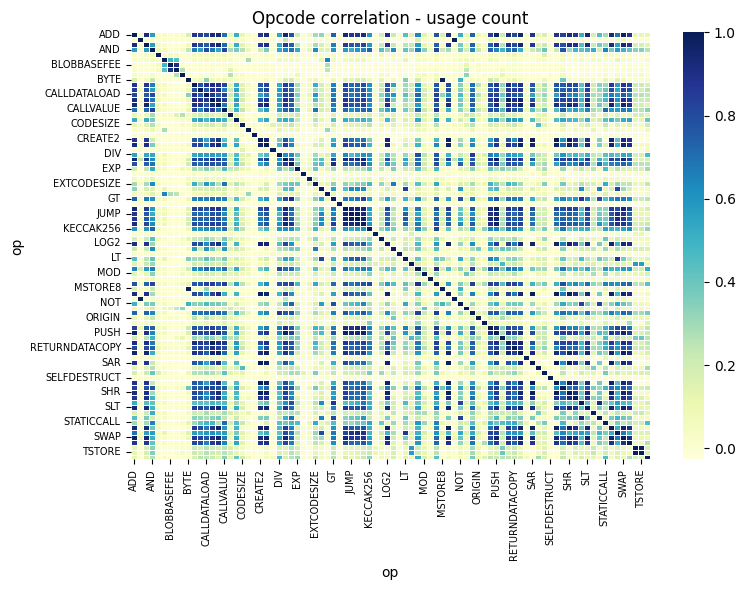

In [11]:
temp_df = pd.pivot_table(
    usage_df[~usage_df["op"].isin(["NO_TRACE", "RESPONSE_TOO_LARGE"])],
    values="op_gas_pair_count",
    index="tx_hash",
    columns="op",
    aggfunc="sum",
    fill_value=0.0,
)
corr_mat = temp_df.corr()
plt.figure(figsize=(8, 6))
ax = sns.heatmap(corr_mat, cmap="YlGnBu", linewidths=0.5)
plt.title("Opcode correlation - usage count")
ax.tick_params(axis="x", labelsize=7)
ax.tick_params(axis="y", labelsize=7)
plt.tight_layout()
plt.show()

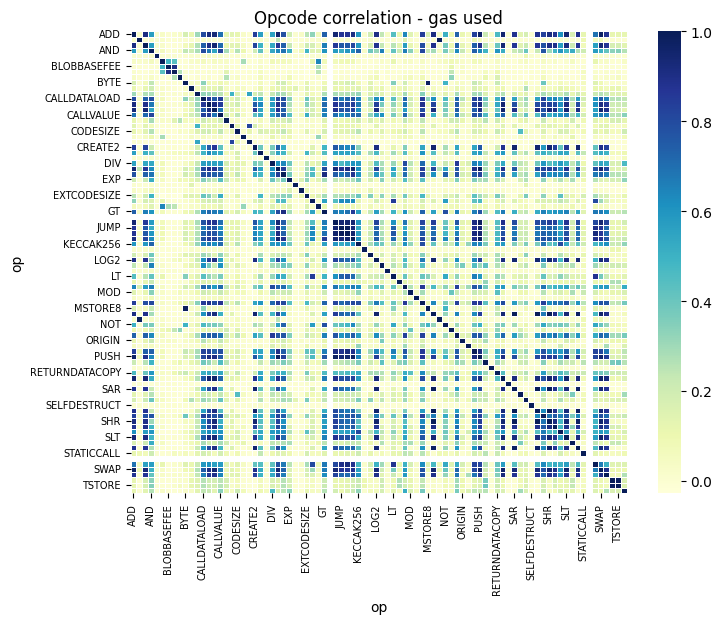

In [12]:
temp_df = pd.pivot_table(
    usage_df[~usage_df["op"].isin(["NO_TRACE", "RESPONSE_TOO_LARGE"])],
    values="op_total_gas_cost",
    index="tx_hash",
    columns="op",
    aggfunc="sum",
    fill_value=0.0,
)
corr_mat = temp_df.corr()
plt.figure(figsize=(8, 6))
ax = sns.heatmap(corr_mat, cmap="YlGnBu", linewidths=0.5)
plt.title("Opcode correlation - gas used")
ax.tick_params(axis="x", labelsize=7)
ax.tick_params(axis="y", labelsize=7)
plt.show()

## 5. Opcode gas usage vs transaction gas usage

Next, we will compare the total gas cost of the transaction with the cost of all opcodes used in the transaction. There are four main components to consider:

1. The intrinsic cost of the transaction, which is a fixed value of 21000 gas units or 53000 gas units when the transaction is a contract creation.
2. The cost of the input data, which costs 4 gas units for each zero bytes and 16 gas units for each non-zero byte.
3. The cost of the opcodes, which is the sum of all opcodes used in the transaction.
4. The gas refunds applied at the end of the transaction, which reduces the total gas cost. These refunds are triggered when the transaction uses the `SSTORE` opcode to set a storage slot to zero.

We already have the input data cost computed, and we can add the opcode costs from our data. The intrinsic cost is trivial. So, the final piece we need to compute is the gas refund. For simplicity, we will assume that the gas refund will be the difference between the total gas used by the transaction and the remaining terms.


In [28]:
op_tx_df = (
    usage_df.groupby(["block_height", "tx_hash"])
    .agg(
        {
            "op_total_gas_cost": "sum",
            "tx_gas_cost": "first",
            "tx_input_data_gas_cost": "first",
            "is_contract_creation": "max",
            "is_success": "max",
        }
    )
    .reset_index()
)
op_tx_df.columns = [
    "block_height",
    "tx_hash",
    "op_gas_cost",
    "tx_gas_cost",
    "tx_input_data_cost",
    "is_contract_creation",
    "is_success",
]
op_tx_df["tx_gas_refund_estimated"] = np.where(
    op_tx_df["is_contract_creation"]==1,
    op_tx_df["op_gas_cost"] + op_tx_df["tx_input_data_cost"] + 53000.0 - op_tx_df["tx_gas_cost"],
    op_tx_df["op_gas_cost"] + op_tx_df["tx_input_data_cost"] + 21000.0 - op_tx_df["tx_gas_cost"],
)
op_tx_df["tx_gas_refund_rate"] =  np.where(
    op_tx_df["is_contract_creation"]==1,
    op_tx_df["tx_gas_refund_estimated"]/(op_tx_df["op_gas_cost"] + op_tx_df["tx_input_data_cost"] + 53000.0),
    op_tx_df["tx_gas_refund_estimated"]/(op_tx_df["op_gas_cost"] + op_tx_df["tx_input_data_cost"] + 21000.0),
)
op_tx_df.head()

,block_height,tx_hash,op_gas_cost,tx_gas_cost,tx_input_data_cost,is_contract_creation,is_success,tx_gas_refund_estimated,tx_gas_refund_rate
0,22000020,0x029c1f067919e7ef9387862fa0624b98a2a3624ec581...,141594.0,160530,736,0,true,2800.0,0.017143
1,22000020,0x0395c4139f9b563fe264651b47699842a6fdaf704cbe...,51859.0,105495,2136,0,true,-30500.0,-0.406694
2,22000020,0x050ff26618ce1c10b47644ac628e3648e96c6b217d25...,0.0,21064,64,0,true,0.0,0.000000
3,22000020,0x070584ade4418b6cffa46b54888d33a86f44f1359e78...,0.0,21000,0,0,true,0.0,0.000000
4,22000020,0x0786a329bb718b8afc44465662b6546273eac1d6e728...,8130.0,24890,560,0,true,4800.0,0.161671


Let's check the gas refunds.

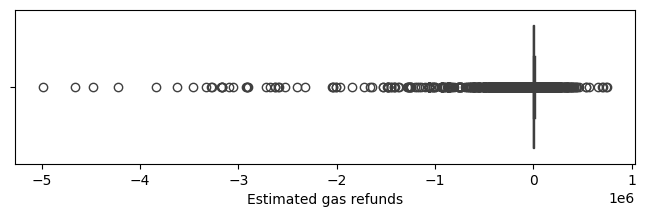

In [14]:
plt.figure(figsize=(8, 2))
sns.boxplot(data=op_tx_df, x="tx_gas_refund_estimated")
plt.xlabel("Estimated gas refunds")
plt.show()

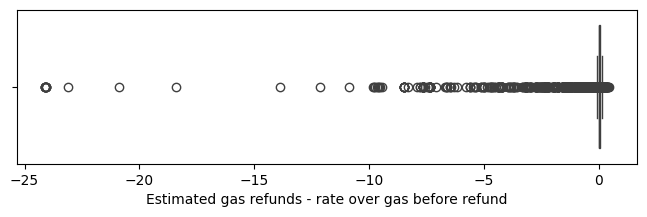

In [15]:
plt.figure(figsize=(8, 2))
sns.boxplot(data=op_tx_df, x="tx_gas_refund_rate")
plt.xlabel("Estimated gas refunds - rate over gas before refund")
plt.show()

We are still seeing some cases where the gas refund is higher than 20% of the original gas cost. There are 0.39% of such transactions.

In [34]:
high_refund_df = op_tx_df[op_tx_df["tx_gas_refund_rate"]>0.2]
print(len(high_refund_df)/len(op_tx_df))
high_refund_df

0.0003883347029066159


,block_height,tx_hash,op_gas_cost,tx_gas_cost,tx_input_data_cost,is_contract_creation,is_success,tx_gas_refund_estimated,tx_gas_refund_rate
256,22000022,0x7ebfe6b8e3b95e355e23759161dd0e4755b010cc52f5...,43703.0,45299,596,0,false,20000.0,0.306283
1065,22000029,0xceac9389bfbd9ebe287cb3d1d3195e917514ba38ed0e...,57869.0,59525,656,0,false,20000.0,0.251493
4972,22000061,0xaf924ad3e94e534e5e8b34fec71e64e2fe57dec31360...,105802.0,97919,596,0,true,29479.0,0.231393
6501,22000076,0xa1561a4323cb257da68ec15cbadf382ee357ab7fc48d...,57869.0,59525,656,0,false,20000.0,0.251493
6669,22000078,0x4657b5e65d55f36d62f79533f2cdcab0dc71ed0e2424...,39709.0,46467,584,0,false,14826.0,0.241887
...,...,...,...,...,...,...,...,...,...
270340,22001909,0x9461adfb5c903384b8aec5c02fb94d09f3384b72b79b...,43317.0,42262,0,0,false,22055.0,0.342911
271070,22001913,0xb62029f87406605839e1a39819a4b3e6cd209a7cf351...,58332.0,59928,596,0,false,20000.0,0.250225
279361,22001955,0xee5fbb1b571298bba3e25d21e3813a6c80b686613cbf...,57869.0,59525,656,0,false,20000.0,0.251493
281095,22001963,0xb3d229a03a171b3dec24d107178d12a7237616360093...,52501.0,54145,644,0,false,20000.0,0.269742


The first thing to point out is that a significant majority are failed transactions.

In [32]:
high_refund_df["is_success"].value_counts()

is_success
false    93
true     19
Name: count, dtype: int64

When the failure is due to an "out of gas" error, the actual cost for the opcode where the error occurred will be lower than what appears in the gas cost column. The actual cost can be computed as the difference between the available gas at the start and the end of that opcode. This is something we should fix in a future version.

In addition, we are still seeing 2.7% of transactions with negative refunds, which indicates that we are missing some gas costs.

In [35]:
negative_refund_df = op_tx_df[op_tx_df["tx_gas_refund_rate"]<0]
print(sum(op_tx_df["tx_gas_refund_rate"]<0)/len(op_tx_df))
negative_refund_df

0.027734725790625185


,block_height,tx_hash,op_gas_cost,tx_gas_cost,tx_input_data_cost,is_contract_creation,is_success,tx_gas_refund_estimated,tx_gas_refund_rate
1,22000020,0x0395c4139f9b563fe264651b47699842a6fdaf704cbe...,51859.0,105495,2136,0,true,-30500.0,-0.406694
5,22000020,0x0c8d48db350d1120d9c467cf66cd38d3b054b74d247d...,40639.0,87355,416,0,true,-25300.0,-0.407703
67,22000020,0xa42f78bdd54ed82d871230ae3294de3a4745894dc4ab...,47440.0,116656,1016,0,true,-47200.0,-0.679567
97,22000020,0xfcd1d61830478a60fd6d1f812c8d476705111081d2a5...,122099.0,213731,2032,0,true,-68600.0,-0.472676
137,22000021,0x61600e231b00f548879af42f69051ff8728de1ce752e...,75644.0,168022,1588,0,true,-69790.0,-0.710461
...,...,...,...,...,...,...,...,...,...
288030,22001999,0x001ac63eaa0d1f8a4c711c512cef64cf0bce479f3d87...,127168.0,221652,3884,0,true,-69600.0,-0.457738
288054,22001999,0x0ea93d80d9653ad6eefe7be1bee45d8ad42d37d27945...,60476.0,112248,2172,0,true,-28600.0,-0.341909
288142,22001999,0x4b8cff998759465f4ec3db78c34efeeea14dab1b464e...,526820.0,728356,18236,0,true,-162300.0,-0.286721
288195,22001999,0x6a3c1cac2d11d90b14024ffc1fb790620e9242f471d8...,85289.0,143501,3912,0,true,-33300.0,-0.302175


After looking at some of these transactions, we realized that we are missing an intrinsic cost component in our calculation. [EIP-2930](https://eips.ethereum.org/EIPS/eip-2930) introduced a transaction type that includes a list of addresses and storage keys that the transaction plans to access. These transactions have an additional cost of 2400 for each address and 1900 for each storage key. This cost is paid like the intrinsic costs, so before any opcodes are executed. We still need to figure out how to isolate these costs - another ToDo for a future of the data pipeline version.